<a href="https://colab.research.google.com/github/XiangxiangXu/NFE/blob/main/MaxCorr_Normal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Set GPU.

In [1]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [2]:
import torch

In [3]:
import numpy as np


In [4]:
# number of samples
nSamples_train = 50000
nSamples_test = 10000
nSamples = nSamples_train + nSamples_test


## Parameters for Training
# batch size
batchsize = 128

# number of epochs
nEpochs = 100

dim = 5

In [5]:
rho = .8
La = np.array([[1, rho], [rho, 1]])
XY = np.random.multivariate_normal(mean = [0, 0], cov = La, size = nSamples)
X = XY[:, 0]
Y = XY[:, 1]

(array([1.000e+00, 3.000e+00, 1.200e+01, 2.300e+01, 9.200e+01, 1.540e+02,
        3.140e+02, 6.370e+02, 1.168e+03, 2.070e+03, 2.916e+03, 4.067e+03,
        5.202e+03, 6.073e+03, 6.691e+03, 6.797e+03, 6.322e+03, 5.313e+03,
        4.260e+03, 3.066e+03, 2.098e+03, 1.260e+03, 7.590e+02, 3.770e+02,
        2.070e+02, 7.100e+01, 3.200e+01, 1.000e+01, 3.000e+00, 2.000e+00]),
 array([-4.31211885, -4.02627612, -3.74043339, -3.45459066, -3.16874794,
        -2.88290521, -2.59706248, -2.31121975, -2.02537702, -1.7395343 ,
        -1.45369157, -1.16784884, -0.88200611, -0.59616339, -0.31032066,
        -0.02447793,  0.2613648 ,  0.54720753,  0.83305025,  1.11889298,
         1.40473571,  1.69057844,  1.97642116,  2.26226389,  2.54810662,
         2.83394935,  3.11979208,  3.4056348 ,  3.69147753,  3.97732026,
         4.26316299]),
 <BarContainer object of 30 artists>)

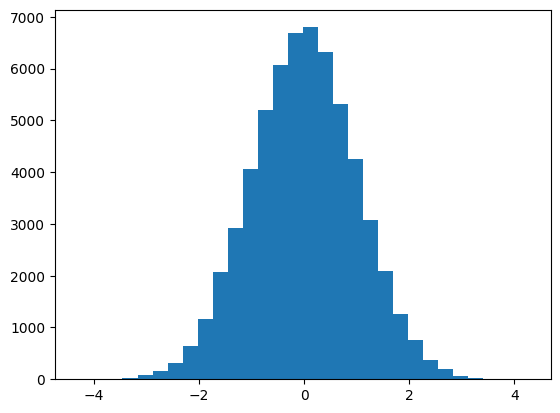

In [6]:
from matplotlib import pyplot as plt
plt.hist(X, 30)

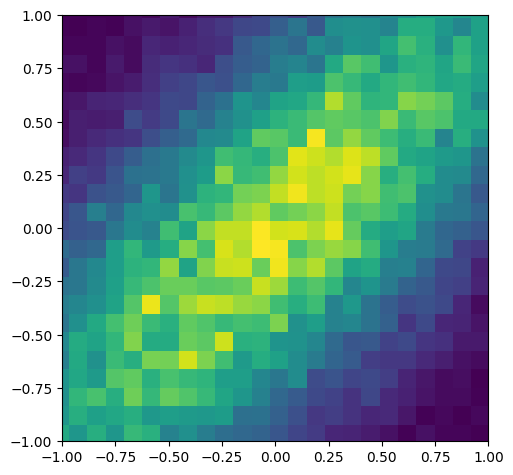

In [7]:
plt.hist2d(X, Y, 100)

plt.tight_layout()
plt.axis([-1, 1, -1, 1])
plt.gca().set_aspect('equal', adjustable='box')#plt.axis('equal')

In [8]:
from torch.utils.data import TensorDataset, DataLoader
Xt = torch.tensor(X, dtype=torch.float32)
Yt = torch.tensor(Y, dtype=torch.float32)
# dataloder for training
Xt_train = Xt[:nSamples_train]
Yt_train = Yt[:nSamples_train]

ds = TensorDataset(Xt_train, Yt_train)
dl = DataLoader(ds, batch_size=batchsize, shuffle = True)

# test data
X_test = X[nSamples_train:]
Y_test = Y[nSamples_train:]

Xt_test = Xt[nSamples_train:]
Yt_test = Yt[nSamples_train:]

In [9]:
from torch import nn, optim
import torch.nn.functional as F
class mlp(nn.Module):
    def __init__(self, dim_list, activation = F.relu):
        super().__init__()
        self.fc_list = nn.ModuleList([nn.Linear(dim_list[i], dim_list[i+1]) for i in range(len(dim_list) - 1)])
        self.activation = activation

    def forward(self, x):
        num_layers = len(self.fc_list)
        for i in range(num_layers):
            x = self.fc_list[i](x)
            if i != num_layers - 1: # activate except for the last layer
                x = self.activation(x)
        return x

class mlp_parallel(nn.Module):
    def __init__(self, dim_list, m = 1, activation = F.relu):
        super().__init__()
        self.mlp_list = nn.ModuleList([mlp(dim_list, activation) for i in range(m)])

    def forward(self, x):
        f = torch.cat([mlp_(x) for mlp_ in self.mlp_list], axis = -1)
        return f

class fg_nn(nn.Module): # f_net, g_net
    def __init__(self, f_net, g_net):
        super().__init__()
        self.f_net = f_net
        self.g_net = g_net

    def forward(self, x, y):
        f = self.f_net(x)
        g = self.g_net(y)
        return f, g

    def get_f(self, x):
        f = self.f_net(x)
        return f

    def get_g(self, y):
        g = self.g_net(y)
        return g


f_net = mlp([1, 128, 64, dim], activation = F.softplus) #  mlp_parallel([1, 32, 32, 1], m = dim, activation = F.softplus) #
g_net = mlp([1, 128, 64, dim], activation = F.softplus) # mlp_parallel([1, 32, 32, 1], m = dim, activation = F.softplus) #

model = fg_nn(f_net, g_net)
# model.to(device)
opt = optim.Adam(model.parameters()) # optim.RMSprop(model.parameters(), lr = 1e-3) # or Adam

In [10]:
centralize = lambda x: x - torch.mean(x, 0) # zero-mean
cov = lambda x: x.T @ x / (x.size()[0]-1.) # covariance

def neg_hscore(f, g):
    """
    compute the negative h-score
    """
    f0 = centralize(f)
    g0 = centralize(g)
    corr = torch.mean(torch.sum(f0*g0, 1))
    # to generate zero-mean f, g
    cov_f = cov(f)
    cov_g = cov(g)
    return - corr + torch.trace(cov_f @ cov_g) / 2.

def stop_grad(x):
    # return deatched x (except the last dim)
    return torch.cat((x[:, :-1].detach(), x[:, [-1]]), axis = -1)


def neg_hscore_nest(f, g, dim0 = 0):
    """
    compute the (nagative) nested H-score:

    from dim0
    """
    f_dim = f.shape[1]
    neg_h_nest = torch.sum(torch.stack(
        [neg_hscore(stop_grad(f[:, :i+1]), stop_grad(g[:, :i+1])) # stop_grad
         for i in range(dim0, f_dim)]))
    return neg_h_nest

In [11]:
for epoch in range(nEpochs):
    for x, y in dl:
        f_, g_ = model(x.reshape(-1, 1), y.reshape(-1, 1))
        loss = neg_hscore_nest(f_, g_)
        loss.backward()
        opt.step()
        opt.zero_grad()
    if epoch % 10 == 0:
        print('epoch:', epoch, '/', nEpochs)# 'training neg_h_score =', loss)


epoch: 0 / 100
epoch: 10 / 100
epoch: 20 / 100
epoch: 30 / 100
epoch: 40 / 100
epoch: 50 / 100
epoch: 60 / 100
epoch: 70 / 100
epoch: 80 / 100
epoch: 90 / 100


In [12]:
detach = lambda x: x.cpu().detach().numpy()
norm = lambda x: np.sqrt(np.mean(x**2))

# get features on the training set
f_train = detach(model.get_f(Xt_train.reshape(-1, 1)))
g_train = detach(model.get_g(Yt_train.reshape(-1, 1)))

# compute norm for each dimension
norm_f = np.zeros(dim)
norm_g = np.zeros(dim)
#mu_f = np.zeros(dim)
#mu_g = np.zeros(dim)
for i in range(dim):
    #mu_f[i] = np.mean(f_train[:, i])
    norm_f[i] = norm(f_train[:, i])
    #mu_g[i] = np.mean(g_test[:, i])
    norm_g[i] = norm(g_train[:, i])

Xt_grid = torch.linspace(-1, 1, steps=1000).reshape(-1, 1)
X_grid = detach(Xt_grid).reshape(-1)
Yt_grid = Xt_grid
Y_grid = X_grid

f_grid = detach(model.get_f(Xt_grid))
g_grid = detach(model.get_g(Yt_grid))





In [13]:
#  https://en.wikipedia.org/wiki/Mehler_kernel#Probability_version
from scipy import special

def scaled_hermite_prob(n):
    # n-th order probabilist's Hermite polynomials, scaled by 1/sqrt(n!)
    hermite = special.hermitenorm(n, monic=True)
    func = lambda x: hermite(x)/np.sqrt(special.factorial(n))
    return func


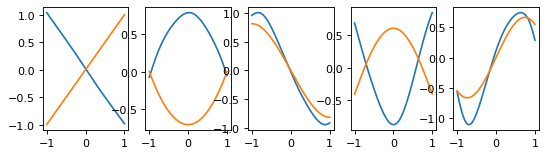

In [14]:
plt.figure(figsize=(8, 2), dpi=80)
# normalize ...
for i in range(dim):
    f_gt = scaled_hermite_prob(i+1)
    plt.subplot(1, dim, i+1)
    plt.plot(X_grid, f_grid[:, i]/norm_f[i])

    plt.plot(X_grid, f_gt(X_grid))



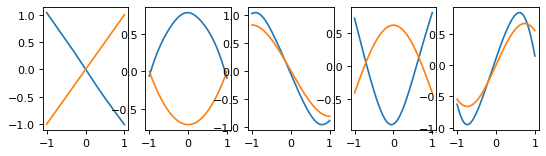

In [15]:
plt.figure(figsize=(8, 2), dpi=80)
# normalize ...
for i in range(dim):
    plt.subplot(1, dim, i+1)
    plt.plot(Y_grid, g_grid[:, i]/norm_g[i])

    g_gt = scaled_hermite_prob(i+1)
    plt.plot(Y_grid, g_gt(Y_grid))

In [16]:
# get features on the testing set
f_test = model.get_f(Xt_test.reshape(-1, 1)).detach().numpy()
g_test = model.get_g(Yt_test.reshape(-1, 1)).detach().numpy()

# # compute stand deviations for each dimension
# std_f = np.zeros(dim)
# std_g = np.zeros(dim)
# mu_f = np.zeros(dim)
# mu_g = np.zeros(dim)
# for i in range(dim):
#     mu_f[i] = np.mean(f_test[:, i])
#     std_f[i] = np.std(f_test[:, i])
#     mu_g[i] = np.mean(g_test[:, i])
#     std_g[i] = np.std(g_test[:, i])

Compute Correlation

In [17]:
# compute the correlation coefficients between x, y
corr = lambda x, y: (np.corrcoef(x.reshape(-1), y.reshape(-1)))[0, 1]


print('corr(x, y) =', corr(X, Y))




corr(x, y) = 0.8002401620540558


Correlation between different modes

In [18]:

for i in range(dim):
    print('corr(f' + str(i+1) + '(x), g' + str(i+1) + '(x)) =', corr(f_test[:, i], g_test[:, i]))

corr(f1(x), g1(x)) = 0.8001543137538488
corr(f2(x), g2(x)) = 0.6409110087864017
corr(f3(x), g3(x)) = 0.50220038362506
corr(f4(x), g4(x)) = 0.3888116609936453
corr(f5(x), g5(x)) = 0.2942762565610331


Ground Truth

In [19]:
[rho ** i for i in range(1, dim+1)]

[0.8,
 0.6400000000000001,
 0.5120000000000001,
 0.4096000000000001,
 0.3276800000000001]

Check uncorrelatedness

In [20]:

# uncorrelatedness
print('corr(f1(x), f2(x)) =', corr(f_test[:, 0], f_test[:, 1]))
print('corr(f1(x), g2(y)) =', corr(f_test[:, 0], g_test[:, 1]))

corr(f1(x), f2(x)) = -0.02739937313948036
corr(f1(x), g2(y)) = -0.006048738886154336
